In [1]:
! pip install tensorflow keras numpy matplotlib opencv-python scikit-learn

  You can safely remove it manually.



  Using cached tensorboard-2.19.0-py3-none-any.whl.metadata (1.8 kB)
  Using cached keras-3.10.0-py3-none-any.whl.metadata (6.0 kB)
  Using cached numpy-2.0.2-cp39-cp39-win_amd64.whl.metadata (59 kB)
Using cached numpy-2.0.2-cp39-cp39-win_amd64.whl (15.9 MB)
Using cached tensorboard-2.19.0-py3-none-any.whl (5.5 MB)
Using cached keras-3.10.0-py3-none-any.whl (1.4 MB)
   ---------------------------------------- 0.0/39.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/39.5 MB ? eta -:--:--
   ---------------------------------------- 0.3/39.5 MB ? eta -:--:--
   ---------------------------------------- 0.3/39.5 MB ? eta -:--:--
   ---------------------------------------- 0.3/39.5 MB ? eta -:--:--
   ---------------------------------------- 0.3/39.5 MB ? eta -:--:--
   ---------------------------------------- 0.3/39.5 MB ? eta -:--:--
   ---------------------------------------- 0.3/39.5 MB ? eta -:--:--
   ---------------------------------------- 0.3/39.5 MB ? eta -:--:--


In [4]:
! pip uninstall tensorflow tensorflow-gpu keras -y  
! pip install --upgrade tensorflow  

Found existing installation: tensorflow 2.19.0
Uninstalling tensorflow-2.19.0:
  Successfully uninstalled tensorflow-2.19.0
Found existing installation: keras 3.10.0
Uninstalling keras-3.10.0:
  Successfully uninstalled keras-3.10.0


You can safely remove it manually.
You can safely remove it manually.
You can safely remove it manually.


  Using cached tensorflow-2.19.0-cp39-cp39-win_amd64.whl.metadata (4.1 kB)
  Using cached keras-3.10.0-py3-none-any.whl.metadata (6.0 kB)
Using cached tensorflow-2.19.0-cp39-cp39-win_amd64.whl (375.7 MB)
Using cached keras-3.10.0-py3-none-any.whl (1.4 MB)

   ---------------------------------------- 0/2 [keras]
   ---------------------------------------- 0/2 [keras]
   ---------------------------------------- 0/2 [keras]
   ---------------------------------------- 0/2 [keras]
   ---------------------------------------- 0/2 [keras]
   ---------------------------------------- 0/2 [keras]
   ---------------------------------------- 0/2 [keras]
   ---------------------------------------- 0/2 [keras]
   ---------------------------------------- 0/2 [keras]
   ---------------------------------------- 0/2 [keras]
   ---------------------------------------- 0/2 [keras]
   ---------------------------------------- 0/2 [keras]
   ---------------------------------------- 0/2 [keras]
   ------------

2. Importation des bibliothèques nécessaires

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.utils import to_categorical
import cv2
import seaborn as sns

3. Configuration des paramètres

In [ ]:
# Paramètres
IMAGE_SIZE = (64, 64)  # Taille des images dans EuroSAT
BATCH_SIZE = 32
EPOCHS = 50
LEARNING_RATE = 0.001
NUM_CLASSES = 2  # Sécheresse vs Non-sécheresse
INPUT_SHAPE = (64, 64, 3)  # EuroSAT images are 64x64 with 3 channels

# Chemins des données 
DATA_PATH = "C:\\Users\\Amina\\Documents\\MASTER STE\\S2\\AI\\Projet\\EuroSAT_RGB"  

4. Préparation des données

In [ ]:
def load_and_preprocess_data(data_path):
    images = []
    labels = []
    
    # Classes pertinentes pour la détection de sécheresse
    
    class_mapping = {
    'AnnualCrop': 1,        # Sécheresse
    'Forest': 0,            # Non-sécheresse
    'HerbaceousVegetation': 1,  # Sécheresse
    'Highway': 0,
    'Industrial': 0,
    'Pasture': 1,           # Sécheresse
    'PermanentCrop': 1,     # Sécheresse
    'Residential': 0,
    'River': 0,
    'SeaLake': 0
}
    
    # Parcourir les dossiers et charger les images
    for class_name in os.listdir(data_path):
        class_path = os.path.join(data_path, class_name)
        if not os.path.isdir(class_path):
            continue
            
        for image_file in os.listdir(class_path):
            if image_file.endswith('.jpg'):
                image_path = os.path.join(class_path, image_file)
                
                # Charger et redimensionner l'image
                image = cv2.imread(image_path)
                image = cv2.resize(image, IMAGE_SIZE)
                image = image / 255.0  # Normalisation
                
                images.append(image)
                labels.append(class_mapping.get(class_name, 0))
    
    return np.array(images), np.array(labels)

# Chargement des données
X, y = load_and_preprocess_data(DATA_PATH)

# Division des données (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Conversion des labels en format one-hot
y_train = to_categorical(y_train, NUM_CLASSES)
y_test = to_categorical(y_test, NUM_CLASSES)

print(f"Nombre d'images d'entraînement: {len(X_train)}")
print(f"Nombre d'images de test: {len(X_test)}")
print(f"Distribution des classes (train): {np.sum(y_train, axis=0)}")
print(f"Distribution des classes (test): {np.sum(y_test, axis=0)}")

Nombre d'images d'entraînement: 21600
Nombre d'images de test: 5400
Distribution des classes (train): [13200.  8400.]
Distribution des classes (test): [3300. 2100.]


5. Augmentation des données

In [15]:
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE)

6. Construction du modèle

In [ ]:
def build_model(input_shape, num_classes):
    # Utilisation de ResNet50 comme backbone (pré-entraîné sur ImageNet)
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    
    # Congeler les couches du modèle de base
    for layer in base_model.layers:
        layer.trainable = False
    
    # Ajouter des couches personnalisées
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    predictions = layers.Dense(num_classes, activation='softmax')(x)
    
    # Créer le modèle final
    model = models.Model(inputs=base_model.input, outputs=predictions)
    
    return model

model = build_model(INPUT_SHAPE, NUM_CLASSES)

# Compilation du modèle
model.compile(
    optimizer=optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 108s 1us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 70, 70, 3) │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 32, 32,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 32, 32,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 32, 32,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 34, 34,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 16, 16,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 16, 16,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 16, 16,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 16, 16,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 16, 16,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 16, 16,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 16, 16,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 16, 16,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 16, 16,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 16, 16,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 16, 16,    │      1,024 │ conv2_block1_3_c

 Total params: 24,112,770 (91.98 MB)

 Trainable params: 525,058 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

7. Callbacks et entraînement

In [17]:
# Callbacks
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-6
)

model_checkpoint = callbacks.ModelCheckpoint(
    'best_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)

# Entraînement
history = model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, reduce_lr, model_checkpoint]
)

c:\Users\Amina\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 595ms/step - accuracy: 0.5929 - loss: 0.6830

675/675 ━━━━━━━━━━━━━━━━━━━━ 538s 778ms/step - accuracy: 0.5929 - loss: 0.6829 - val_accuracy: 0.6111 - val_loss: 0.6509 - learning_rate: 0.0010
Epoch 2/50
675/675 ━━━━━━━━━━━━━━━━━━━━ 529s 784ms/step - accuracy: 0.6073 - loss: 0.6522 - val_accuracy: 0.6111 - val_loss: 0.6394 - learning_rate: 0.0010
Epoch 3/50
675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 743ms/step - accuracy: 0.6054 - loss: 0.6457

675/675 ━━━━━━━━━━━━━━━━━━━━ 647s 958ms/step - accuracy: 0.6055 - loss: 0.6457 - val_accuracy: 0.6119 - val_loss: 0.6342 - learning_rate: 0.0010
Epoch 4/50
675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step - accuracy: 0.6198 - loss: 0.6362

675/675 ━━━━━━━━━━━━━━━━━━━━ 395s 586ms/step - accuracy: 0.6198 - loss: 0.6362 - val_accuracy: 0.6172 - val_loss: 0.6305 - learning_rate: 0.0010
Epoch 5/50
675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step - accuracy: 0.6256 - loss: 0.6332

675/675 ━━━━━━━━━━━━━━━━━━━━ 366s 542ms/step - accuracy: 0.6256 - loss: 0.6332 - val_accuracy: 0.6254 - val_loss: 0.6237 - learning_rate: 0.0010
Epoch 6/50
675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 552ms/step - accuracy: 0.6256 - loss: 0.6333

675/675 ━━━━━━━━━━━━━━━━━━━━ 474s 703ms/step - accuracy: 0.6256 - loss: 0.6333 - val_accuracy: 0.6296 - val_loss: 0.6286 - learning_rate: 0.0010
Epoch 7/50
675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 614ms/step - accuracy: 0.6343 - loss: 0.6225

675/675 ━━━━━━━━━━━━━━━━━━━━ 518s 767ms/step - accuracy: 0.6344 - loss: 0.6225 - val_accuracy: 0.6502 - val_loss: 0.6113 - learning_rate: 0.0010
Epoch 8/50
675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 780ms/step - accuracy: 0.6450 - loss: 0.6166

675/675 ━━━━━━━━━━━━━━━━━━━━ 633s 938ms/step - accuracy: 0.6450 - loss: 0.6166 - val_accuracy: 0.6594 - val_loss: 0.6038 - learning_rate: 0.0010
Epoch 9/50
675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 612ms/step - accuracy: 0.6475 - loss: 0.6133

675/675 ━━━━━━━━━━━━━━━━━━━━ 529s 783ms/step - accuracy: 0.6475 - loss: 0.6133 - val_accuracy: 0.6709 - val_loss: 0.5953 - learning_rate: 0.0010
Epoch 10/50
675/675 ━━━━━━━━━━━━━━━━━━━━ 573s 846ms/step - accuracy: 0.6488 - loss: 0.6032 - val_accuracy: 0.6513 - val_loss: 0.6065 - learning_rate: 0.0010
Epoch 11/50
675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 602ms/step - accuracy: 0.6413 - loss: 0.6127

675/675 ━━━━━━━━━━━━━━━━━━━━ 500s 741ms/step - accuracy: 0.6413 - loss: 0.6127 - val_accuracy: 0.6985 - val_loss: 0.5990 - learning_rate: 0.0010
Epoch 12/50
675/675 ━━━━━━━━━━━━━━━━━━━━ 438s 648ms/step - accuracy: 0.6447 - loss: 0.6114 - val_accuracy: 0.6587 - val_loss: 0.5855 - learning_rate: 0.0010
Epoch 13/50
675/675 ━━━━━━━━━━━━━━━━━━━━ 416s 616ms/step - accuracy: 0.6454 - loss: 0.6007 - val_accuracy: 0.6557 - val_loss: 0.5844 - learning_rate: 0.0010
Epoch 14/50
675/675 ━━━━━━━━━━━━━━━━━━━━ 387s 573ms/step - accuracy: 0.6541 - loss: 0.5905 - val_accuracy: 0.6717 - val_loss: 0.5788 - learning_rate: 0.0010
Epoch 15/50
675/675 ━━━━━━━━━━━━━━━━━━━━ 397s 589ms/step - accuracy: 0.6497 - loss: 0.5844 - val_accuracy: 0.6870 - val_loss: 0.5771 - learning_rate: 0.0010
Epoch 16/50
675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step - accuracy: 0.6484 - loss: 0.5841

675/675 ━━━━━━━━━━━━━━━━━━━━ 398s 590ms/step - accuracy: 0.6484 - loss: 0.5841 - val_accuracy: 0.7239 - val_loss: 0.5879 - learning_rate: 0.0010
Epoch 17/50
675/675 ━━━━━━━━━━━━━━━━━━━━ 396s 586ms/step - accuracy: 0.6529 - loss: 0.5949 - val_accuracy: 0.6839 - val_loss: 0.5883 - learning_rate: 0.0010
Epoch 18/50
675/675 ━━━━━━━━━━━━━━━━━━━━ 361s 536ms/step - accuracy: 0.6448 - loss: 0.5993 - val_accuracy: 0.6113 - val_loss: 0.5977 - learning_rate: 0.0010
Epoch 19/50
675/675 ━━━━━━━━━━━━━━━━━━━━ 358s 531ms/step - accuracy: 0.6181 - loss: 0.6115 - val_accuracy: 0.6404 - val_loss: 0.5992 - learning_rate: 0.0010
Epoch 20/50
675/675 ━━━━━━━━━━━━━━━━━━━━ 362s 537ms/step - accuracy: 0.6541 - loss: 0.5907 - val_accuracy: 0.7024 - val_loss: 0.5948 - learning_rate: 0.0010
Epoch 21/50
675/675 ━━━━━━━━━━━━━━━━━━━━ 369s 547ms/step - accuracy: 0.6655 - loss: 0.5884 - val_accuracy: 0.7044 - val_loss: 0.5788 - learning_rate: 2.0000e-04
Epoch 22/50
675/675 ━━━━━━━━━━━━━━━━━━━━ 456s 676ms/step - accurac

8. Évaluation du modèle

169/169 - 84s - 496ms/step - accuracy: 0.7239 - loss: 0.5879

Accuracy sur le jeu de test: 72.39%
169/169 ━━━━━━━━━━━━━━━━━━━━ 88s 498ms/step


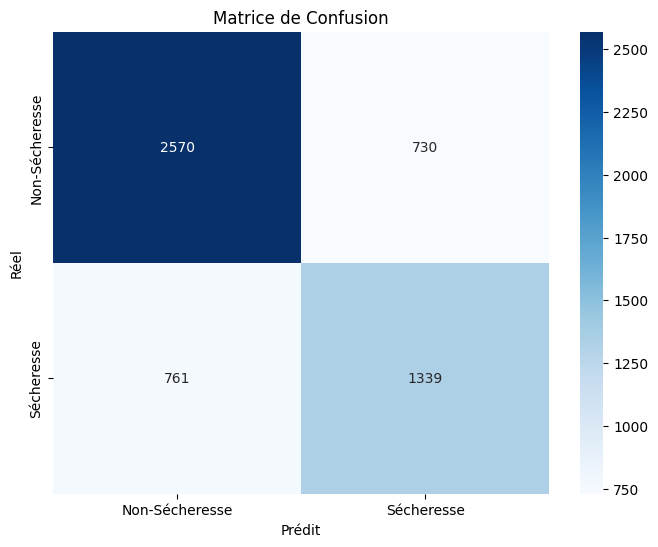

                precision    recall  f1-score   support

Non-Sécheresse       0.77      0.78      0.78      3300
    Sécheresse       0.65      0.64      0.64      2100

      accuracy                           0.72      5400
     macro avg       0.71      0.71      0.71      5400
  weighted avg       0.72      0.72      0.72      5400



In [18]:
# Charger le meilleur modèle
model = models.load_model('best_model.h5')

# Évaluation sur le jeu de test
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f"\nAccuracy sur le jeu de test: {test_acc*100:.2f}%")

# Prédictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Matrice de confusion
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Non-Sécheresse', 'Sécheresse'], 
            yticklabels=['Non-Sécheresse', 'Sécheresse'])
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.title('Matrice de Confusion')
plt.show()

# Rapport de classification
print(classification_report(y_true, y_pred_classes, target_names=['Non-Sécheresse', 'Sécheresse']))

9. Visualisation des résultats

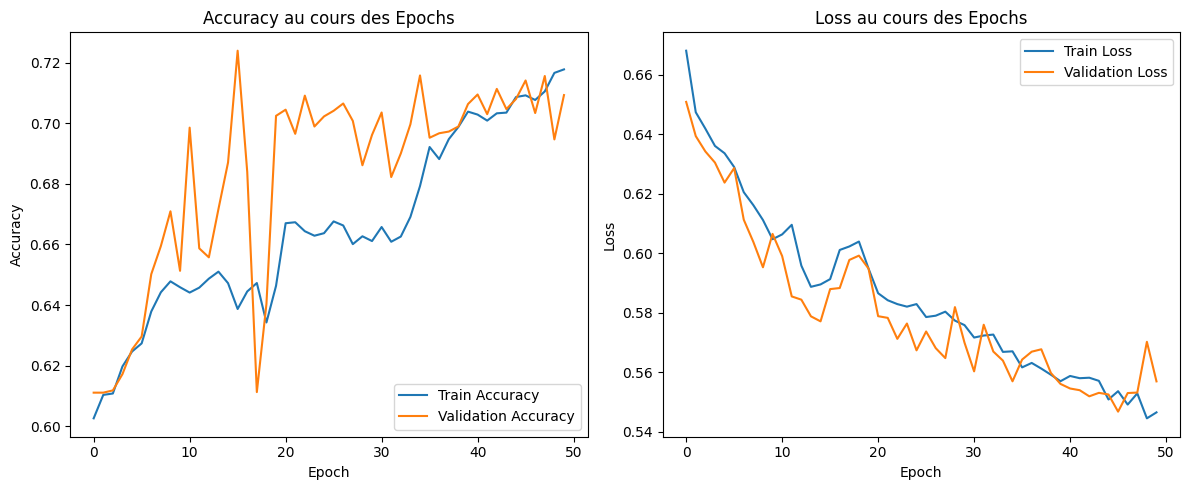

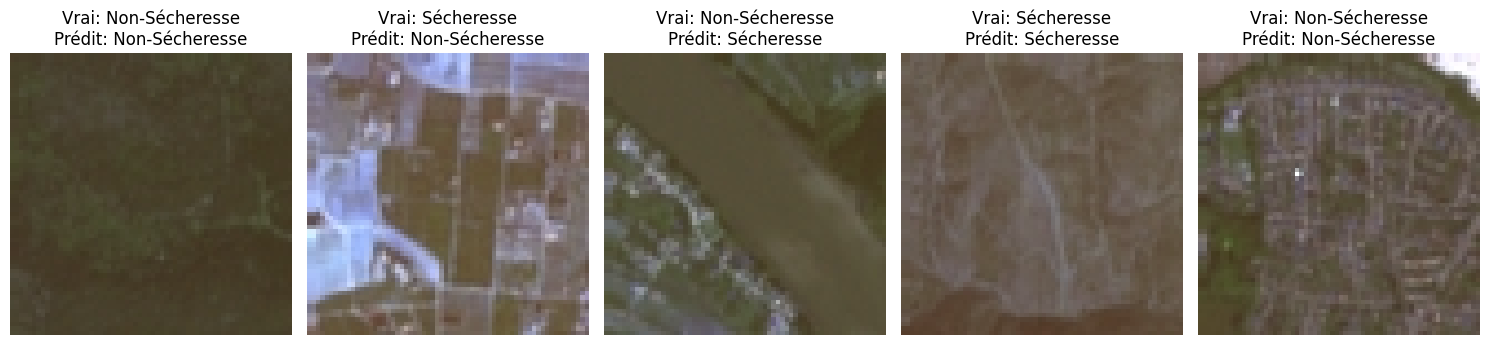

In [19]:
# Courbes d'apprentissage
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy au cours des Epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss au cours des Epochs')

plt.tight_layout()
plt.show()

# Visualisation de quelques prédictions
def plot_predictions(images, true_labels, pred_labels, num_images=5):
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(images[i])
        true_class = 'Sécheresse' if true_labels[i] == 1 else 'Non-Sécheresse'
        pred_class = 'Sécheresse' if pred_labels[i] == 1 else 'Non-Sécheresse'
        plt.title(f'Vrai: {true_class}\nPrédit: {pred_class}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Sélectionner quelques images de test
indices = np.random.choice(range(len(X_test)), 5)
sample_images = X_test[indices]
sample_true = y_true[indices]
sample_pred = y_pred_classes[indices]

plot_predictions(sample_images, sample_true, sample_pred)

10. Sauvegarde et utilisation du modèle

In [21]:
# Sauvegarde du modèle final
model.save('drought_detection_model.keras')


# Fonction pour prédire sur une nouvelle image
def predict_drought(image_path, model):
    # Charger et prétraiter l'image
    img = cv2.imread(image_path)
    img = cv2.resize(img, IMAGE_SIZE)
    img = img / 255.0
    img = np.expand_dims(img, axis=0)  # Ajouter une dimension de batch
    
    # Prédiction
    prediction = model.predict(img)
    class_idx = np.argmax(prediction)
    confidence = np.max(prediction)
    
    # Interprétation
    class_label = "Sécheresse" if class_idx == 1 else "Non-Sécheresse"
    
    # Afficher le résultat
    plt.imshow(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB))
    plt.title(f"{class_label} (Confiance: {confidence*100:.2f}%)")
    plt.axis('off')
    plt.show()
    
    return class_label, confidence

# Exemple d'utilisation
# image_path = "chemin/vers/votre/image.jpg"
# predict_drought(image_path, model)